# Loan Default Prediction

<img src="http://jihoon-kim.synology.me/wp-content/uploads/2017/07/LOAN-1024x512.jpg">

## Import Modules

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.version

'3.5.3 |Continuum Analytics, Inc.| (default, Mar  6 2017, 11:58:13) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

# Load Data

Data is provided by Kaggle Datasets(https://www.kaggle.com/wendykan/lending-club-loan-data).

### Data Description
>These files contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. The file is a matrix of about 890 thousand observations and 75 variables. A data dictionary is provided in a separate file.

In [2]:
# load data
loan = pd.read_csv('./data/loan.csv')

/home/jihoon_kim/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Pre-Processing
Let's quickly explore how this data looks like.

In [3]:
loan.dtypes

id                               int64
member_id                        int64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs              

In [4]:
loan.isnull().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       51457
emp_length                          0
home_ownership                      0
annual_inc                          4
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           761350
purpose                             0
title                             151
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        29
earliest_cr_

There are some columns with huge number of null values! I will drop these columns.

In [5]:
null_cols = ['desc',
             'mths_since_last_delinq',
             'mths_since_last_record',
             'next_pymnt_d',
             'mths_since_last_major_derog',
             'annual_inc_joint',
             'dti_joint',
             'verification_status_joint',
             'open_acc_6m',
             'open_il_6m',
             'open_il_12m',
             'open_il_24m',
             'mths_since_rcnt_il',
             'total_bal_il',
             'il_util',
             'open_rv_12m',
             'open_rv_24m',
             'max_bal_bc',
             'all_util',
             'inq_fi',
             'total_cu_tl',
             'inq_last_12m'
             ]

In [6]:
def drop_null_columns(data):
    """Drop columns (most of values are null)"""
    data.drop(null_cols, axis=1, inplace=True)
    return None

In [7]:
drop_null_columns(loan)

## Modifying Target Column

The target column I am interested in is `loan_status`. Let's explore how this column is composed of.

In [8]:
loan.loan_status.value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Meaning of loan status is described below:

|Loan Status|Meaning|
|---:|:---|
|Current|Loan is up to date on all outstanding payments.|
|Fully Paid|Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.|
|Charged Off|Loan for which there is no longer a reasonable expectation of further payments. Generally, Charge Off occurs no later than 30 days after the Default status is reached. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance.|
|Late (31-120 days)|Loan has not been current for 31 to 120 days.|
|Issued|New loan that has passed all LendingClub reviews, received full funding, and has been issued.|
|In Grace Period|Loan is past due but within the 15-day grace period.|
|Late (16-30 days)|Loan has not been current for 16 to 30 days.|
|Default|Loan has not been current for 121 days or more.|

First of all, `Current` and `Issued` loans are still in progress, so they cannot be used for training. Let's split them.

In [9]:
in_progress_index = ['Current', 'Issued']

In [10]:
def split_loan_in_progress(data):
    """Return table of loan in progress. It drops the loan in progress from loan data internally."""
    progress_bool = data.loan_status.isin(in_progress_index)
    loan_in_progress = data[progress_bool].drop('loan_status', axis=1)
    data.drop(list(loan_in_progress.index), axis=0, inplace=True)
    return loan_in_progress

In [11]:
loan_in_progress = split_loan_in_progress(loan)

In [12]:
print("Shape of loan_in_progress:", loan_in_progress.shape)
print("Shape of loan            :", loan.shape)

Shape of loan_in_progress: (610239, 51)
Shape of loan            : (277140, 52)


There are many classes in `loan_status` feature. However, I want to divide it to 3 classses: bad, warning and safe.


<table>
  <tr>
    <td>Loan Status</td>
    <td>Class</td>
    <td>Code</td>
  </tr>
  <tr>
    <td>Fully Paid</td>
    <td rowspan="2">Safe</td>
    <td rowspan="2">2</td>
  </tr>
  <tr>
    <td>Does not meet the credit policy. Status:Fully Paid</td>
  </tr>
  <tr>
    <td>Late (31-120 days)</td>
    <td rowspan="3">Warning</td>
    <td rowspan="3">1</td>
  </tr>
  <tr>
    <td>Late (16-30 days)</td>
  </tr>
  <tr>
    <td>In Grace Period</td>
  </tr>
  <tr>
    <td>Charged Off</td>
    <td rowspan="3">Bad</td>
    <td rowspan="3">0</td>
  </tr>
  <tr>
    <td>Does not meet the credit policy. Status:Charged Off</td>
  </tr>
  <tr>
    <td>Default</td>
  </tr>
</table>

This categorization is coded as:

In [13]:
bad_index = ['Charged Off',
             'Does not meet the credit policy. Status:Charged Off',
             'Default'
             ]

warning_index = ['Late (31-120 days)',
                 'Late (16-30 days)',
                 'In Grace Period'          # (Late (1-15 days)
                 ]

safe_index = ['Fully Paid',
              'Does not meet the credit policy. Status:Fully Paid'
              ]

In [14]:
def categorize_target(data):
    """Returns encoded loan status: Safe, Warning and Bad"""

    def func(x):
        if x['loan_status'] in bad_index:
            return 0
        elif x['loan_status'] in warning_index:
            return 1
        else:
            return 2

    data['loan_status_coded'] = data.apply(func, axis=1)
    data.drop('loan_status', axis=1, inplace=True)
    return data

In [15]:
loan = categorize_target(loan)

In [16]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status_coded
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,171.62,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,649.91,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,357.48,Jan-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,161.03,Sep-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2


# Exploratory Data Analysis

Now, we have pre-processed data table as `loan`. Let's explore distribution of each features to understand data.

In [30]:
loan.dtypes

id                              int64
member_id                       int64
loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
sub_grade                       int64
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
pymnt_plan                     object
url                            object
purpose                        object
title                          object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
inq_last_6mths                float64
open_acc    

### loan_amnt 
* loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

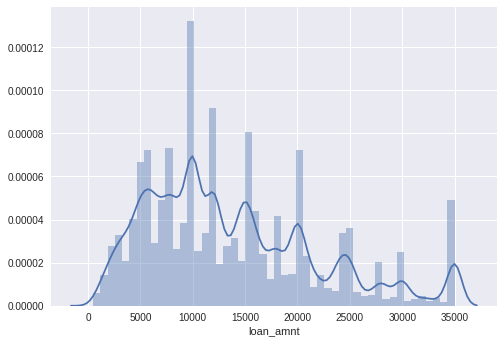

In [18]:
sns.distplot(loan["loan_amnt"])

### funded_amnt, funded_amnt_inv
* funded_amnt: The total amount committed to that loan at that point in time.
* funded_amnt_inv: The total amount committed by investors for that loan at that point in time.

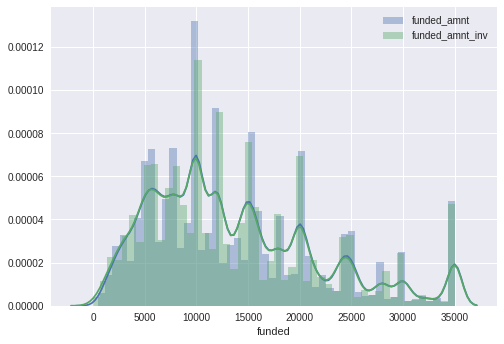

In [19]:
plt.figure()
sns.distplot(loan["funded_amnt"], label="funded_amnt")
sns.distplot(loan["funded_amnt_inv"], label="funded_amnt_inv")
plt.legend()
plt.xlabel("funded")
plt.show()

### term
* term: The number of payments on the loan. Values are in months and can be either 36 or 60.

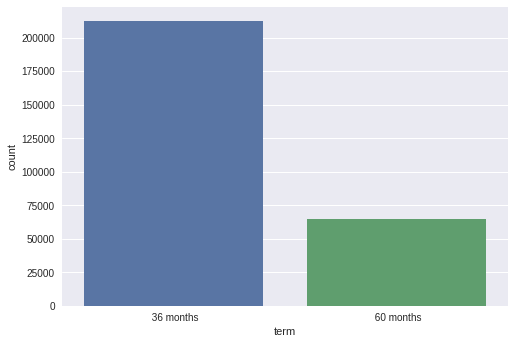

In [20]:
sns.countplot(loan["term"])

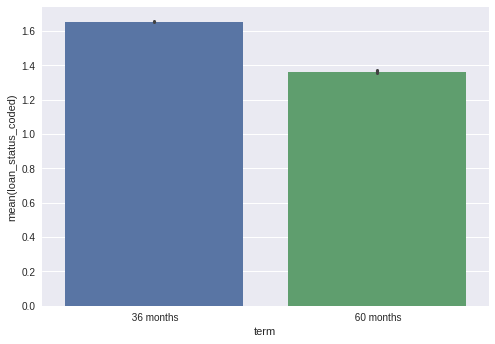

In [21]:
sns.barplot(x="term", y="loan_status_coded", data=loan)

### int_rate
* int_rate: Interest Rate on the loan

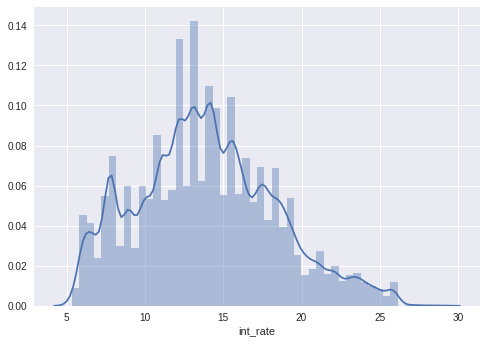

In [22]:
sns.distplot(loan["int_rate"])

### installment

* installment: The monthly payment owed by the borrower if the loan originates.

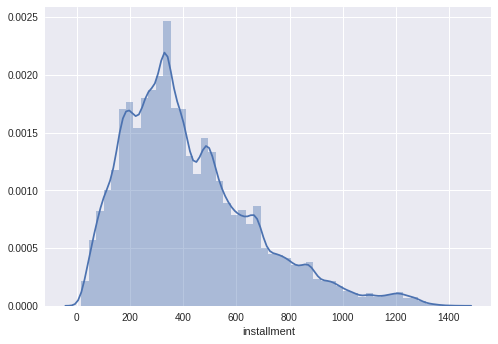

In [23]:
sns.distplot(loan["installment"])

### grade, sub_grade
* grade: LC assigned loan grade
* sub_grade: LC assigned loan subgrade

#### grade

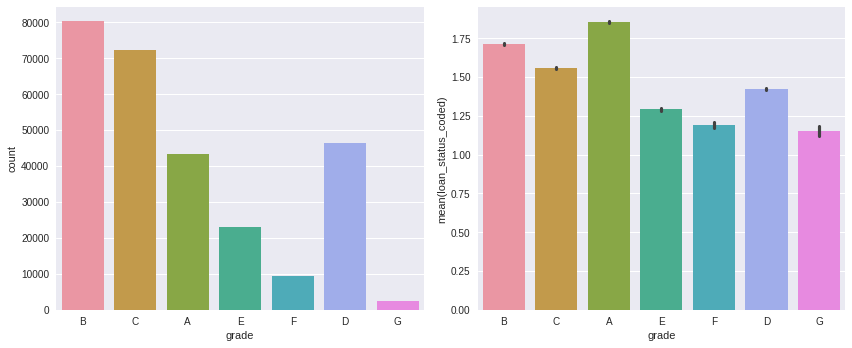

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["grade"])
plt.subplot(1,2,2)
sns.barplot(x="grade", y="loan_status_coded", data=loan)
plt.tight_layout()
plt.show()

#### sub_grade

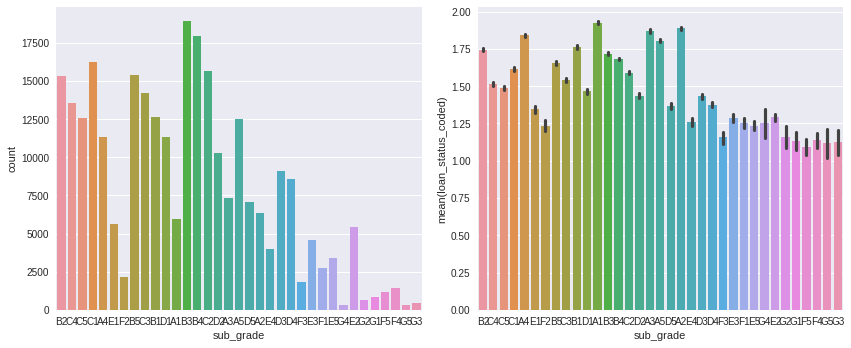

In [25]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["sub_grade"])
plt.subplot(1,2,2)
sns.barplot(x="sub_grade", y="loan_status_coded", data=loan)
plt.tight_layout()
plt.show()

It would be better to extract just a number from `sub_grade` rather than using combined form since the grade information is already provided by `grade` feature.

In [26]:
def ext_num_from_sub_grade(data):
    data['sub_grade'] = data['sub_grade'].map(lambda x: int(x.lstrip('ABCDEFG')))
    return data

In [27]:
loan = ext_num_from_sub_grade(loan)

In [28]:
loan.sub_grade.value_counts()

4    57124
3    56406
2    55869
1    55389
5    52352
Name: sub_grade, dtype: int64

Now, `sub_grade` feature only contains numeric data. Let's plot this feature again.

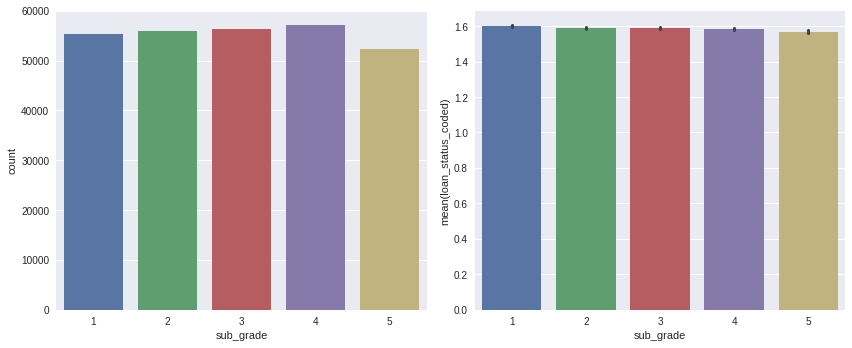

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["sub_grade"])
plt.subplot(1,2,2)
sns.barplot(x="sub_grade", y="loan_status_coded", data=loan)
plt.tight_layout()
plt.show()

### emp_title
* The job title supplied by the Borrower when applying for the loan.

In [37]:
loan.emp_title.isnull().sum()/loan.shape[0] * 100

5.5524283755502637

5% of `emp_title` feature is filled with null value.

In [39]:
loan.emp_title.value_counts().head()

Manager             2229
Teacher             2223
Supervisor           995
Registered Nurse     975
RN                   960
Name: emp_title, dtype: int64

In [43]:
loan.emp_title.value_counts()[0]/loan.shape[0] * 100

0.8042866421303313

Although the most frequently answered position is 'Manager', but it accounts for only 0.8% of the entire data. I believe this feature can't represent the whole dataset in meaningful way. So I decided to drop this feature.

In [46]:
def drop_emp_title(data):
    data.drop('emp_title', axis=1, inplace=True)
    return None

In [47]:
drop_emp_title(loan)

### emp_length
* emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

In [51]:
loan.emp_length.value_counts()

10+ years    83918
2 years      25828
< 1 year     23210
3 years      22436
5 years      19518
1 year       18643
4 years      17660
6 years      15999
7 years      15281
8 years      13028
n/a          11101
9 years      10518
Name: emp_length, dtype: int64

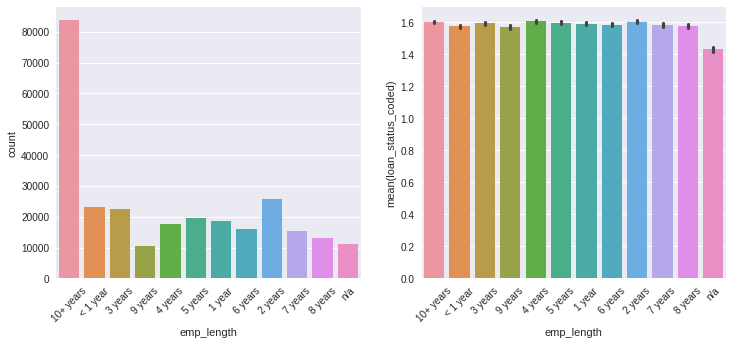

In [56]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["emp_length"])
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.barplot(x="emp_length", y="loan_status_coded", data=loan)
plt.xticks(rotation=45)
plt.show()

### home_ownership
* home_ownership: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

In [57]:
loan.home_ownership.value_counts()

MORTGAGE    135573
RENT        116948
OWN          24391
OTHER          179
NONE            48
ANY              1
Name: home_ownership, dtype: int64

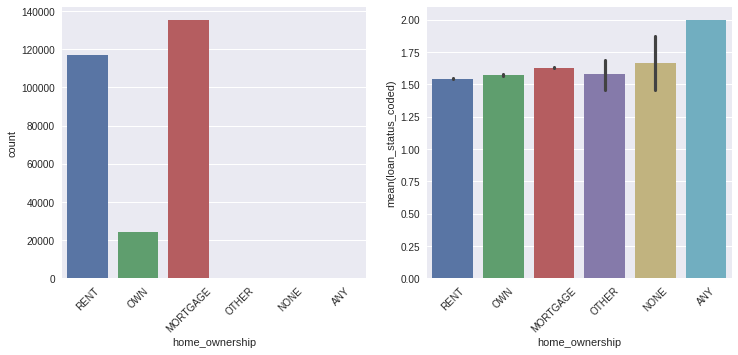

In [58]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["home_ownership"])
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.barplot(x="home_ownership", y="loan_status_coded", data=loan)
plt.xticks(rotation=45)
plt.show()

### annual_inc
* annual_inc: The self-reported annual income provided by the borrower during registration.

In [67]:
loan.annual_inc.isnull().sum()

0

There are only 4 missing values. Let's replace them with median value of feature which is more robust to outlier than mean.

In [70]:
print("Median of annual_inc: ", loan.annual_inc.median())
print("Mean of annual_inc:   ", loan.annual_inc.mean())

Median of annual_inc:  62000.0
Mean of annual_inc:    72483.6595565


In [71]:
loan.annual_inc.fillna(loan.annual_inc.median(), inplace=True)

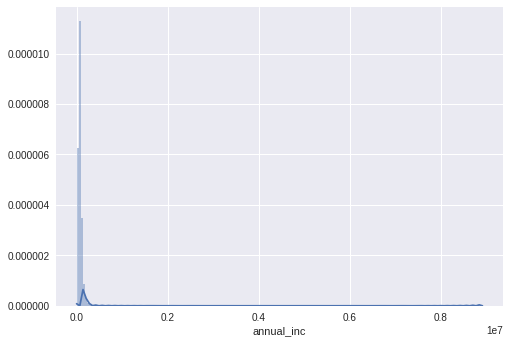

In [77]:
sns.distplot(loan["annual_inc"], bins=200)

(0, 500000)

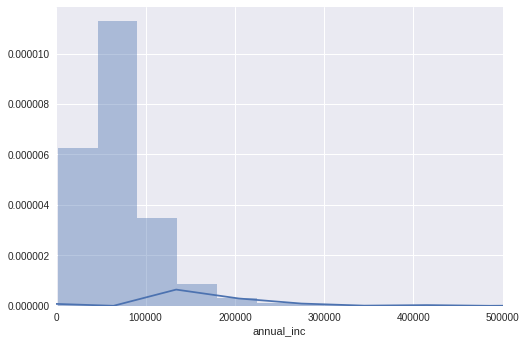

In [78]:
sns.distplot(loan["annual_inc"], bins=200)
plt.xlim([0,500000])

We can see that `annual_inc` is heavily skewed.

### verification_status
* verification_status

In [79]:
loan.verification_status.value_counts()

Verified           101552
Not Verified        92571
Source Verified     83017
Name: verification_status, dtype: int64

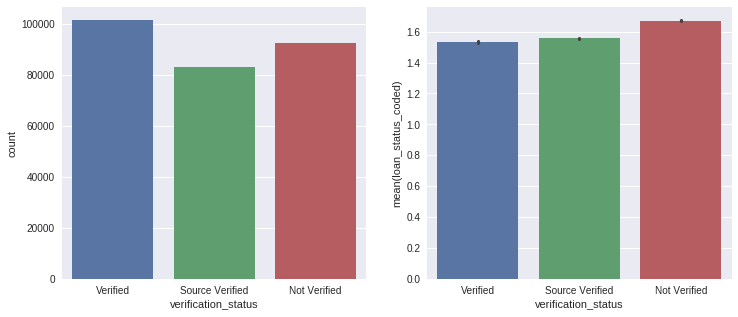

In [83]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(loan["verification_status"])

plt.subplot(1,2,2)
sns.barplot(x="verification_status", y="loan_status_coded", data=loan)
plt.show()

In [59]:
loan.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_length                        0
home_ownership                    0
annual_inc                        4
verification_status               0
issue_d                           0
pymnt_plan                        0
url                               0
purpose                           0
title                            14
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
inq_last_6mths                   29
open_acc                         29
pub_rec                          29
revol_bal                   